# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'boxer_182.jpg'

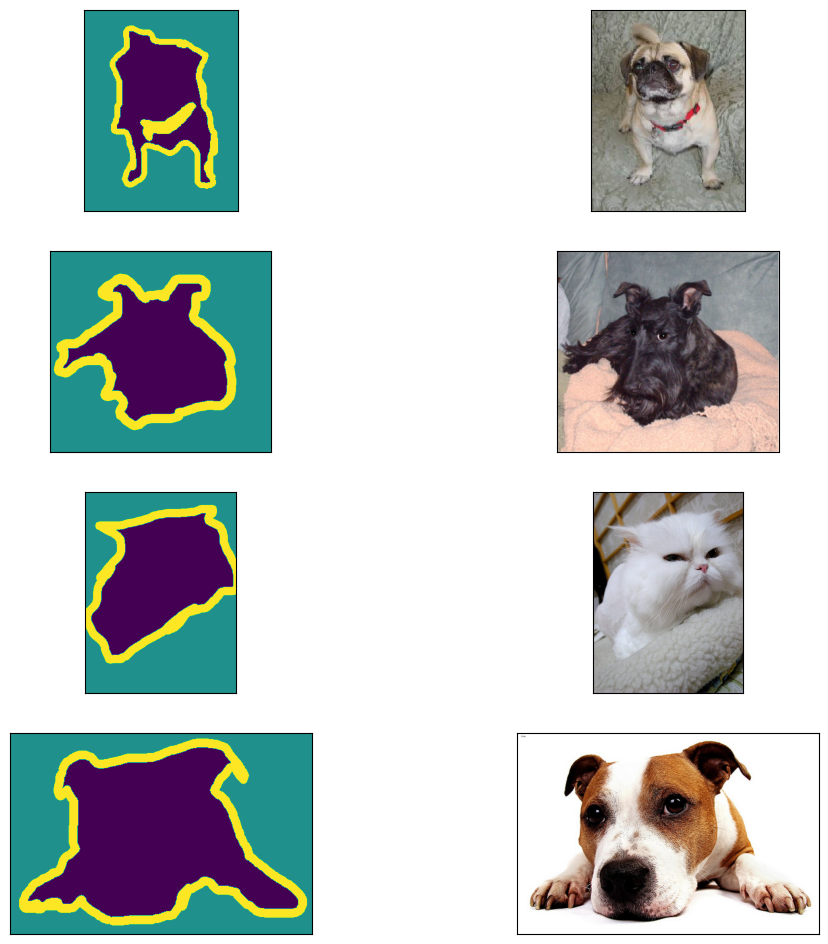

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [75]:
# img = Image.open(os.path.join(trimaps_dir, maps[0]))
# print(np.unique(img))

# SageMaker Setup

In [17]:
from sagemaker import image_uris

role = sagemaker.get_execution_role()
bucket_name = 'petsdata'
training_image = image_uris.retrieve('semantic-segmentation',boto3.Session().region_name,version = 'latest')
print(training_image)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [18]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [19]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:05<00:00, 1407.13it/s]


In [20]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [21]:
print(len(train_annots), len(train_images))

5541 5541


# Uploading Data to S3

In [23]:
bucket_name = 'petsdata-semantic'

In [24]:
sess = sagemaker.Session()
print('Starting Upload...')
s3_train_path = sess.upload_data(path='train',bucket = bucket_name, key_prefix = 'train')
print('Training Images Uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation',bucket = bucket_name, key_prefix = 'train_annotation')

Starting Upload...
Training Images Uploaded


In [25]:
print('Starting Upload...')
s3_validation_path = sess.upload_data(path='validation',bucket = bucket_name, key_prefix = 'validation')
print('validation Images Uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation',bucket = bucket_name, key_prefix = 'validation_annotation')

Starting Upload...
validation Images Uploaded


In [26]:
s3_validation_annotation_path

's3://petsdata-semantic/validation_annotation'

# SageMaker Estimator

In [160]:
model = sagemaker.estimator.Estimator(
    image_uri=training_image,
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://petsdata-semantic/output',
    sagemaker_session=sess
)

# Hyperparameters

In [161]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs = 10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
)

# Data Channels

In [162]:
from sagemaker.inputs import TrainingInput
train_data = TrainingInput(s3_train_path,distribution='FullyReplicated',
                                        content_type='image/jpeg',s3_data_type='S3Prefix')
validation_data = TrainingInput(s3_validation_path,distribution='FullyReplicated',
                                        content_type='image/jpeg',s3_data_type='S3Prefix')

train_annotation_data = TrainingInput(s3_train_annotation_path,distribution='FullyReplicated',
                                        content_type='image/jpeg',s3_data_type='S3Prefix')
validation_annotation_data = TrainingInput(s3_validation_annotation_path,distribution='FullyReplicated',
                                        content_type='image/jpeg',s3_data_type='S3Prefix')

In [163]:
data_channel = {
    'train': train_data,
    'validation': validation_data,
    'train_annotation':train_annotation_data,
    'validation_annotation':validation_annotation_data
}

In [164]:
data_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f6086e36d70>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f6086e36dd0>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f6086e36e00>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f6086e36e60>}

# Model Training

In [165]:
model.fit(inputs=data_channel, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2024-11-15-09-24-39-427


2024-11-15 09:24:42 Starting - Starting the training job...
2024-11-15 09:25:05 Starting - Preparing the instances for training...
2024-11-15 09:25:30 Downloading - Downloading input data............
2024-11-15 09:27:27 Downloading - Downloading the training image.........
2024-11-15 09:29:03 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Nov 15 09:29:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |       

# Deploy Model

In [166]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('model deployed')

INFO:sagemaker:Creating model with name: semantic-segmentation-2024-11-15-10-28-21-763
INFO:sagemaker:Creating endpoint-config with name semantic-segmentation-2024-11-15-10-28-21-763
INFO:sagemaker:Creating endpoint with name semantic-segmentation-2024-11-15-10-28-21-763


-------------!model deployed


# Predictions

In [167]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1849


In [196]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [197]:
index = 0

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)



In [198]:
mask = np.array(Image.open(io.BytesIO(results)))


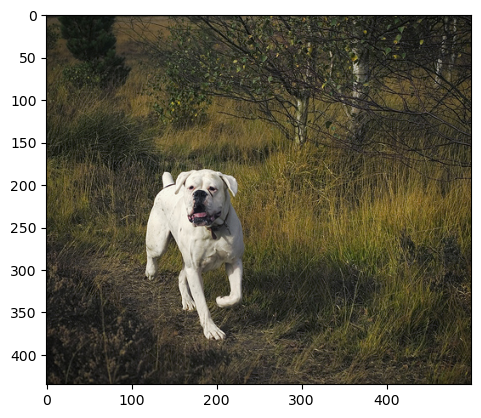

In [199]:
plt.imshow(plt.imread(image_path));

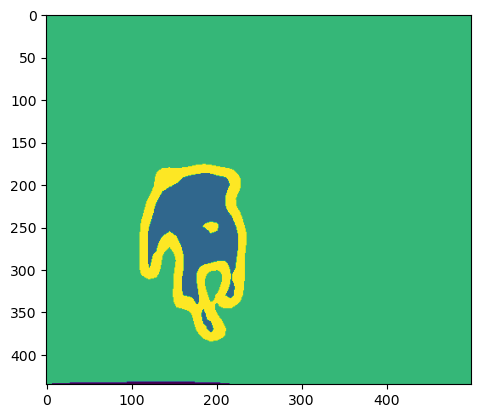

In [200]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [201]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: semantic-segmentation-2024-11-15-10-28-21-763
